In [1]:
import os
import numpy as np
from PIL import Image

def read_images(image_folder, target_size=(256, 256)):
    """
    Read and resize images from the specified folder.

    Args:
        image_folder (str): Path to the folder containing images.
        target_size (tuple): Target size for resizing images.

    Returns:
        list: List containing numpy arrays of images.
    """
    try:
        images = []
        for filename in sorted(os.listdir(image_folder)):
            # Read and resize image
            with Image.open(os.path.join(image_folder, filename)) as image:
                image = np.array(image.resize(target_size))
                images.append(image)
        return images
    except Exception as e:
        print(f"Error reading images: {e}")
        return None

def read_masks(mask_folder, target_size=(256, 256)):
    """
    Read and resize masks from the specified folder.

    Args:
        mask_folder (str): Path to the folder containing masks.
        target_size (tuple): Target size for resizing masks.

    Returns:
        list: List containing PIL Image objects of masks.
    """
    try:
        masks = []
        for mask_filename in sorted(os.listdir(mask_folder)):
            # Read and resize mask
            with Image.open(os.path.join(mask_folder, mask_filename)) as mask:
                mask = mask.resize(target_size)
                mask = mask.convert('L')  # Convert to grayscale
                masks.append(mask)
        return masks
    except Exception as e:
        print(f"Error reading masks: {e}")
        return None

# Example usage
image_folder = "/kaggle/input/train-data/dataset2/images"
mask_folder = "/kaggle/input/train-data/dataset2/masks"

images = np.array(read_images(image_folder))
masks = np.array(read_masks(mask_folder))


In [2]:
# Create a dataset from images and masks.
from datasets import Dataset
dataset_dict = {
    "image": [Image.fromarray(img) for img in images],
    "label": [Image.fromarray(mask) for mask in masks],
}

dataset = Dataset.from_dict(dataset_dict)

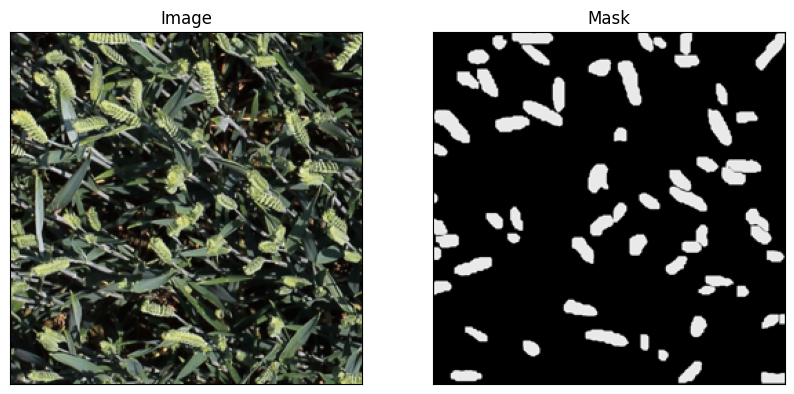

In [6]:
import random
import matplotlib.pyplot as plt

img_num = random.randint(0, images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [7]:
def get_bounding_box(ground_truth_map):
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)

  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [8]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [9]:
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

2024-03-05 11:59:53.270088: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 11:59:53.270190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 11:59:53.407811: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [10]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [11]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [12]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [13]:
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-large")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

In [14]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.6 MB/s eta 0:00:0000:01


In [15]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceFocalLoss(sigmoid=True, squared_pred=True, reduction='mean')

In [20]:
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2.0 * intersection) / (union + np.finfo(float).eps)


In [23]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      ground_truth_masks = normalize(threshold(ground_truth_masks, 0.0, 0)).to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()
      
      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())
     

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

     

100%|██████████| 400/400 [09:01<00:00,  1.35s/it]


EPOCH: 0
Mean loss: 0.2416139011271298


100%|██████████| 400/400 [09:02<00:00,  1.36s/it]


EPOCH: 1
Mean loss: 0.23179096879437566


100%|██████████| 400/400 [09:01<00:00,  1.35s/it]


EPOCH: 2
Mean loss: 0.22379359817132355


100%|██████████| 400/400 [09:02<00:00,  1.36s/it]


EPOCH: 3
Mean loss: 0.21800785502418876


100%|██████████| 400/400 [09:02<00:00,  1.36s/it]


EPOCH: 4
Mean loss: 0.21230195242911576


100%|██████████| 400/400 [09:02<00:00,  1.36s/it]


EPOCH: 5
Mean loss: 0.20800460932776332


100%|██████████| 400/400 [09:03<00:00,  1.36s/it]


EPOCH: 6
Mean loss: 0.20285500351339578


100%|██████████| 400/400 [09:02<00:00,  1.36s/it]


EPOCH: 7
Mean loss: 0.19958667242899536


100%|██████████| 400/400 [09:01<00:00,  1.35s/it]


EPOCH: 8
Mean loss: 0.1963277762196958


100%|██████████| 400/400 [09:01<00:00,  1.35s/it]

EPOCH: 9
Mean loss: 0.1949893271178007


In [26]:
torch.save(model.state_dict(), "/kaggle/working/model_checkpoint.pth")


In [35]:
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

Output shape: (256, 256)
Unique values in prediction: [0 1]


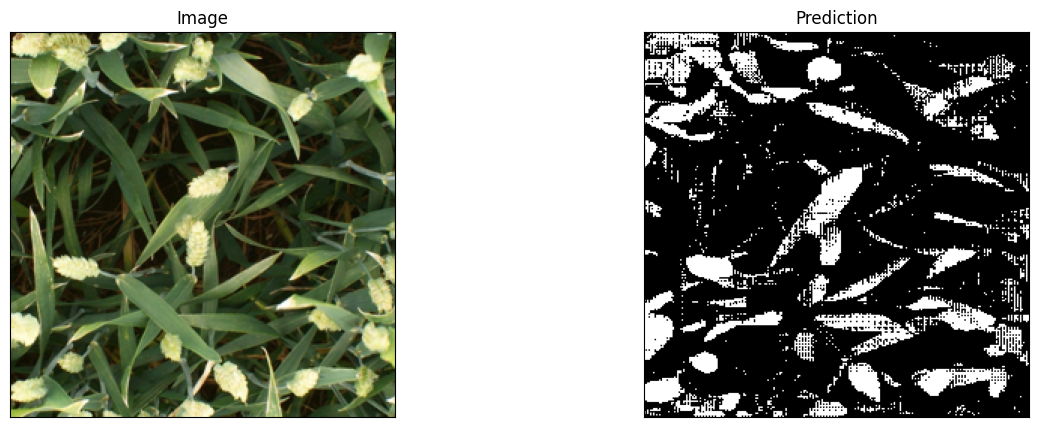

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assuming `read_images` and `processor` functions are defined elsewhere
# and `model` and `input_points` are already defined

# Load test image
test_image_path = "/kaggle/input/test-dataset/testt"
test_images = np.array(read_images(test_image_path))
test_image = test_images[0]

# Prepare single patch image for the model
single_patch = test_image
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inputs = {k: v.to(device) for k, v in inputs.items()}

# Set model to evaluation mode
model.eval()

# Forward pass
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False) 

# Apply sigmoid to predicted masks
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

# Convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.4).astype(np.uint8)

# Display debug information
print("Output shape:", single_patch_prediction.shape)
print("Unique values in prediction:", np.unique(single_patch_prediction))

# Plot images
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the input image
axes[0].imshow(np.array(single_patch), cmap='gray')
axes[0].set_title("Image")

# Plot the predicted mask
axes[1].imshow(single_patch_prediction, cmap='gray')
axes[1].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()
